This is the 4-th post in the series of predicting popularity of a blog post on NYTimes.

The first three are:  
- [Naïve Random Forest Classifier](http://r-train.ru/naive-random-forest-classifier/)
- [Fitting models on low signal-to-noise data](http://r-train.ru/fitting-models-on-low-signal-to-noise-data/)
- [Feature selection 1: Univariate](http://r-train.ru/feature-selection-1-univariate/)

In this post I am going to compare in-model feature section in plain vanilla `LogisticRegression` vs. that plus fitting Random Forest on a reduced number of features.

The plan is as following:

1. [Standard](http://r-train.ru/naive-random-forest-classifier/) preprocessing.
2. Tuning hyperparameters of `LogisticRegression` on a train subset.
3. Validating two models on the validation subset:
    - best `LogisticRegression` with tuned parameters
    - `ExtraTreesClassifier` on a reduced # of features

## Preprocess data

In [1]:
#Load data
import numpy as np
import pandas as pd
seed = 1
train = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTrain.csv')
test = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTest.csv')
combo = pd.merge(train, test, how='outer')
combo = combo.drop('Popular', axis=1)
y = train['Popular']
combo_clean = combo.fillna('empty')
combo_clean['LogWC'] = np.log(.1+ combo_clean['WordCount'])

#Extract Date/time info and bin time
import datetime as dt
combo_clean['date'] = combo_clean['PubDate'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%A')
)
combo_clean['hour'] = combo_clean['PubDate'].apply(
    lambda x: int(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
)
combo_clean[['PubDate','date','hour']][1:5]
bins = np.linspace(0,24,5)
labels = ['night', 'morning', 'afternoon', 'evening']
combo_clean['hour_bins'] = pd.cut(combo_clean['hour'], bins=bins, labels=labels)
combo_clean.drop(['hour', 'WordCount', 'PubDate'], axis=1, inplace=True)

#Make dummies and bags of words
import sklearn.feature_extraction.text as txt
categorical_dummies = pd.get_dummies(combo_clean[['NewsDesk','SectionName','SubsectionName','date', 'hour_bins']])
categorical_dummies.shape
tfidf = txt.TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1, 2),)
tfidf
bwHeadline       = (tfidf.fit_transform(combo_clean['Headline'])).todense()
bwHeadline_names = np.asarray(tfidf.get_feature_names())
bwHeadline_names = np.core.defchararray.add('H_', bwHeadline_names)
bwAbstract       = (tfidf.fit_transform(combo_clean['Abstract'])).todense()
bwAbstract_names = np.asarray(tfidf.get_feature_names())
bwAbstract_names = np.core.defchararray.add('A_', bwAbstract_names)

#Put everything together
data = np.concatenate((categorical_dummies, bwHeadline, bwAbstract), axis=1)
feature_names = np.concatenate((categorical_dummies.columns, bwHeadline_names, bwAbstract_names), axis=0)
data_train = data[: train.shape[0],:]
data_test  = data[train.shape[0]:,:]
import sklearn.cross_validation as cv
data_train, data_val, y_train, y_val = cv.train_test_split(data_train, y, test_size=.2, random_state=seed)

## Tuning LogisticRegression

In [14]:
import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.grid_search as grd
import sklearn.metrics as mts

In [21]:
lg_mod = lm.LogisticRegression(random_state=seed, class_weight='auto')
lg_mod

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0)

In [25]:
param = {'C': np.logspace(-2,2.,100),
        'penalty': ['l1', 'l2']}
gr = grd.GridSearchCV(lg_mod, param_grid=param, scoring = 'roc_auc', cv=10)
gr

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.09750e-02, ...,   9.11163e+01,   1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [26]:
gr.fit(data_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.09750e-02, ...,   9.11163e+01,   1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [39]:
auc_std  = np.array([np.std(i[2]) for i in gr.grid_scores_])
auc_mean = np.array([np.mean(i[2]) for i in gr.grid_scores_])
penalty  = np.array([i[0]['penalty'] for i in gr.grid_scores_])
lower_l1 = auc_mean[penalty == 'l1'] - 2*auc_std[penalty == 'l1']
upper_l1 = auc_mean[penalty == 'l1'] + 2*auc_std[penalty == 'l1']
lower_l2 = auc_mean[penalty == 'l2'] - 2*auc_std[penalty == 'l2']
upper_l2 = auc_mean[penalty == 'l2'] + 2*auc_std[penalty == 'l2']

In [29]:
% matplotlib inline
import matplotlib.pyplot as plt

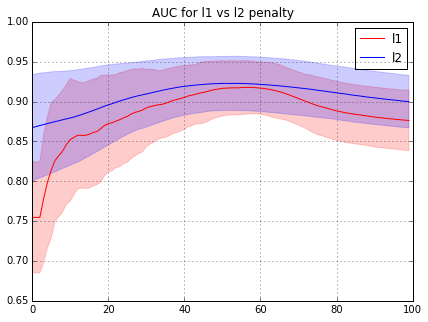

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(auc_mean[penalty == 'l1'], 'r', label = 'l1')
plt.fill_between(np.arange(len(upper_l1)),upper_l1, lower_l1, color='r', alpha=.2)
plt.plot(auc_mean[penalty == 'l2'], 'b', label = 'l2')
plt.fill_between(np.arange(len(upper_l2)),upper_l2, lower_l2, color='b', alpha=.2)
plt.legend(numpoints=1)
plt.grid()
plt.title('AUC for l1 vs l2 penalty')
plt.show()

In [43]:
gr.best_estimator_

LogisticRegression(C=1.5199110829529348, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [189]:
gr.best_score_

0.92274076542906758

## Validating LogisticRegression on held-out test set

In [96]:
best_param = gr.best_estimator_.get_params()
lg_mod.set_params(C = best_param['C'],class_weight = best_param['class_weight'],
                  penalty = best_param['penalty'], random_state = seed)

LogisticRegression(C=1.5199110829529348, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [97]:
lg_mod.fit(data_train, y_train)

LogisticRegression(C=1.5199110829529348, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [99]:
import sklearn.metrics as mts
mts.roc_auc_score(y_val, lg_mod.predict_proba(data_val)[:,1])

0.91514510601841925

## Tuning LogisticRegression for filtering + ExtraTreeClassifier for classifier

In [109]:
import sklearn.ensemble as ens

In [116]:
lg_mod = lm.LogisticRegression(random_state=seed, class_weight='auto', penalty = 'l2')
etc_mod = ens.ExtraTreesClassifier(n_estimators=500, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')


cv_scores = []
c_ = np.linspace(1.3, 1.7, 5)
t_ = np.linspace(.1,.9, 9)
for c in c_:
    print('Regularization parameter "C" is', c)
    lg_mod.set_params(C=c)
    for t in t_:
        print('Threshold selection parameter "threshold" is', t)
        lg_mod.fit(data_train, y_train)
        data_train_filtered = lg_mod.transform(data_train, threshold=t)
        folds = cv.StratifiedShuffleSplit(y=y_train, n_iter=5, test_size=.2, random_state=seed)
        cv_scores.append(cv.cross_val_score(etc_mod, data_train_filtered, y_train,
                                            scoring='roc_auc', cv=folds, n_jobs=-1))

Regularization parameter "C" is 1.3
Threshold selection parameter "threshold" is 0.1
Threshold selection parameter "threshold" is 0.2
Threshold selection parameter "threshold" is 0.3
Threshold selection parameter "threshold" is 0.4
Threshold selection parameter "threshold" is 0.5
Threshold selection parameter "threshold" is 0.6
Threshold selection parameter "threshold" is 0.7
Threshold selection parameter "threshold" is 0.8
Threshold selection parameter "threshold" is 0.9
Regularization parameter "C" is 1.4
Threshold selection parameter "threshold" is 0.1
Threshold selection parameter "threshold" is 0.2
Threshold selection parameter "threshold" is 0.3
Threshold selection parameter "threshold" is 0.4
Threshold selection parameter "threshold" is 0.5
Threshold selection parameter "threshold" is 0.6
Threshold selection parameter "threshold" is 0.7
Threshold selection parameter "threshold" is 0.8
Threshold selection parameter "threshold" is 0.9
Regularization parameter "C" is 1.5
Threshold 

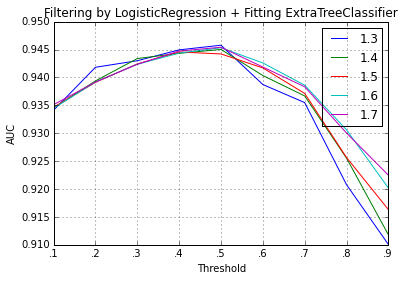

In [164]:
labels = ('1.3', '1.4', '1.5', '1.6', '1.7')
for j in range(5):
    plt.plot(np.mean(cv_scores[0+j*9:9+j*9], axis=1), label=labels[j])
plt.legend()
plt.xticks(np.arange(0,9,1), ('.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9'))
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('Filtering by LogisticRegression + Fitting ExtraTreeClassifier')
plt.grid()
plt.show()

In sum, all solutions reach maximum near regularizing parameter C=1.5. Optimum threshold is in the .4 ÷ .6 range.

## Validating LogisticRegression as Filter + ExtraTreesClassifier as classifier

In [167]:
lg_mod = lm.LogisticRegression(C=1.5, random_state=seed, class_weight='auto')
thrlg_mod.fit(data_train, y_train)

LogisticRegression(C=1.5, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0)

In [186]:
thr = [.4, .5, .6]
for t in thr:
    print("# of parameters left after transformation with %0.1f threshold is %0.3f" % 
          (t,lg_mod.transform(data_train, threshold=t).shape[1]))

# of parameters left after transformation with 0.4 threshold is 837.000
# of parameters left after transformation with 0.5 threshold is 557.000
# of parameters left after transformation with 0.6 threshold is 383.000


Let's try all threshold values (.4, .5, .6) and see how good generalizion to validation set will be.

In [188]:
thr = [.4, .5, .6]
etc_mod = ens.ExtraTreesClassifier(n_estimators=3000, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')


for t in thr:
    data_train_filtered = lg_mod.transform(data_train, threshold=t)
    data_val_filtered = lg_mod.transform(data_val, threshold=t)
    etc_mod.fit(data_train_filtered, y_train)
    auc_ = mts.roc_auc_score(y_val, etc_mod.predict_proba(data_val_filtered)[:,1])
    print("# of parameters left after transformation with %0.1f threshold is %0.3f" % 
          (t, data_train_filtered.shape[1]))
    print("AUC on held-out validation set is %0.5f" % auc_)

# of parameters left after transformation with 0.4 threshold is 837.000
AUC on held-out validation set is 0.90627
# of parameters left after transformation with 0.5 threshold is 557.000
AUC on held-out validation set is 0.89837
# of parameters left after transformation with 0.6 threshold is 383.000
AUC on held-out validation set is 0.89328


## Summary

It's interesting to note the following:
- Plain vanilla Logistic Regression ('l2') tuned on train data and validated on held-out subset:
    - best in-train AUC is **0.92274** 
    - validation AUC on held-out subset is **0.915145**
- Logistic Regression as filter (837 features) + Random Forest as classifier:
    - best in-train AUC is **0.945**
    - validation AUC on held-out subset is **0.90627**
    
It appears, Logistic Regression alone generalizes better than more complicated combination on top of it, leave at alone the speed of fitting Logistic Regression vs Random Forest.